In [1]:
#importing out neccessary modules
import torch as nn
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision
import torch
import torchvision.models as models
import torch.optim as optim


In [2]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [3]:
#writing our device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

### for more information on the different transfer learning architectures look at:
https://docs.pytorch.org/vision/0.9/models.html

In [4]:
resnet = models.resnet50(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 216MB/s]


In [5]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
import torch.nn as nn
# we have to change the final layer because our dataset(SD-198) has 198 classes, unlike the standard 100 that resnet-50 comes with
resnet.fc = nn.Linear(in_features=resnet.fc.in_features, out_features=114)

In [7]:
#freeze all the layers so we won't have to train it fully
for param in resnet.parameters():
  param.requires_grad = False

#unfreeze the fully connected layer
for param in resnet.fc.parameters():
  param.requires_grad = True

In [8]:
#selecting our loss function and optimizers
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(resnet.parameters(), lr=0.001)

In [9]:
#importing our dataset and preparing to create a dataloader
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import zipfile
import os

'''
We are using the dataset "SD-198" this dataset contains over 198 different skin diseases with over 6,000 images contatining images of
skin and respective disease, we downloaded the dataset from Kaggle at : https://www.kaggle.com/datasets/longngzzz/sd-198
'''

skin_data_path = '/content/drive/MyDrive/THEDATASET.zip' #this is the google drive path of the dataset
extract_path = '/content'  # Local Colab path to unzip'''


with zipfile.ZipFile(skin_data_path, 'r') as zip_ref: #this simply just extracts the zip file with data to a certain path
    zip_ref.extractall(extract_path)

In [11]:
from torchvision import transforms
from torch.utils.data import DataLoader,random_split # import random split for later use
from torchvision.datasets import ImageFolder
'''
train_data = transforms.Compose([
    transforms.Resize((224,224)), #resizes img to 224x224 which is what resnet uses
    transforms.ToTensor(), #transforms from PIL to Pytorch Tensor
    transforms.Normalize([0.485,0.456,0.406],
                          [0.229, 0.224, 0.225])

])'''
from torchvision import transforms
 # (left, upper, right, lower)

# Apply the cropping transform + usual preprocessing
train_data = transforms.Compose([

    transforms.Resize((224, 224)),  # resize again for model input

    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


dataset = ImageFolder(root = "/content/THEDATASET", transform = train_data) # this is our data in the form of a Image Folder, we will have to change this into a

train_split = int(0.8*len(dataset))
testing_split = len(dataset)-train_split

train_dataset,test_dataset = random_split(dataset,[train_split,testing_split])

train_loader = DataLoader(train_dataset,batch_size = 32, shuffle = True,drop_last=True)
test_loader = DataLoader(test_dataset,batch_size = 32, shuffle = False,drop_last=True)

In [12]:
classes = train_dataset.dataset.classes
print(classes)
len(classes)

['acanthosis nigricans', 'acne', 'acne vulgaris', 'acquired autoimmune bullous diseaseherpes gestationis', 'acrodermatitis enteropathica', 'actinic keratosis', 'allergic contact dermatitis', 'aplasia cutis', 'basal cell carcinoma', 'basal cell carcinoma morpheiform', 'becker nevus', 'behcets disease', 'calcinosis cutis', 'cheilitis', 'congenital nevus', 'dariers disease', 'dermatofibroma', 'dermatomyositis', 'disseminated actinic porokeratosis', 'drug eruption', 'drug induced pigmentary changes', 'dyshidrotic eczema', 'eczema', 'ehlers danlos syndrome', 'epidermal nevus', 'epidermolysis bullosa', 'erythema annulare centrifigum', 'erythema elevatum diutinum', 'erythema multiforme', 'erythema nodosum', 'factitial dermatitis', 'fixed eruptions', 'folliculitis', 'fordyce spots', 'granuloma annulare', 'granuloma pyogenic', 'hailey hailey disease', 'halo nevus', 'hidradenitis', 'ichthyosis vulgaris', 'incontinentia pigmenti', 'juvenile xanthogranuloma', 'kaposi sarcoma', 'keloid', 'keratosis

114

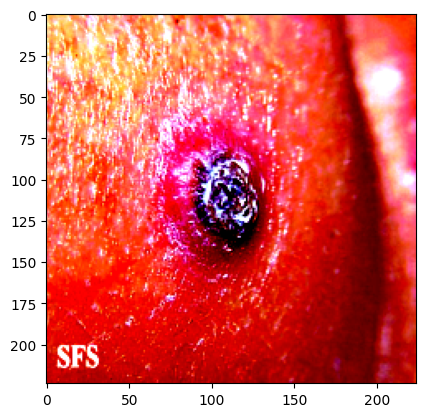

In [13]:
import matplotlib.pyplot as plt
data_iter = iter(train_loader)
images, labels = next(data_iter)
img = images[0].permute(1, 2, 0)
plt.imshow(img)

In [14]:
def accuracy_fn(true_values, prediction_values):
    correct = (true_values == prediction_values).sum()
    return correct.float() / true_values.size(0)  # a single scalar tensor


In [15]:
#importing a function previously made to measure the time
def print_train_time(start:float,
                     end:float,
                     device: torch.device = None):

  "print difference between start and end time"
  total_time = end-start
  print(f"train time on {device}: {total_time:.3f} seconds")

In [16]:
#making our training function

def training_steps(model: torch.nn.Module(),
                   loss_fn: torch.nn.Module(),
                   DataLoader: torch.utils.data.DataLoader,
                   optimizer : torch.optim.Optimizer,
                   accuracy,
                   device: torch.device = device
                   ):

  training_loss,training_accuracy = 0,0
  for batch, (X,y) in enumerate(tqdm(DataLoader)):
    # going throughout the batches
    X,y = X.to(device),y.to(device)


    #do the forward pass
    y_predictions = model(X)

    #calculate loss and do accuracy
    loss = loss_fn(y_predictions,y)
    training_loss +=loss #accumulating the loss so we can divde by total later

    training_accuracy += accuracy(true_values = y, prediction_values = y_predictions.argmax(dim=1)) # accumulating loss so we can divide by total later, using argmax so we can go from logits to actual predictions

    #optim zero grad
    optimizer.zero_grad()
    #backpropagation
    loss.backward()
    #optimizer step
    optimizer.step()
  true_train_loss = training_loss/len(DataLoader)
  true_train_acc = training_accuracy/len(DataLoader)
  print(f" The training loss is {true_train_loss}")
  print(f"the training accuracy is {true_train_acc}")


In [17]:
#making our testing function
def testing_step(model: torch.nn.Module(),
                   loss_fn: torch.nn.Module(),
                   DataLoader: torch.utils.data.DataLoader,
                   optimizer : torch.optim.Optimizer,
                   accuracy,
                   device: torch.device = device):
  testing_loss,testing_accuracy = 0,0

  model.eval()

  with torch.inference_mode():

    for X,y in DataLoader:
      X,y = X.to(device),y.to(device)

      #do the forward pass
      test_predictions = model(X)

      #test loss and test accuracy
      test_loss = loss_fn(test_predictions,y)
      testing_loss += test_loss

      testing_accuracy += accuracy(true_values = y, prediction_values = test_predictions.argmax(dim=1))
      #
    true_test_loss = testing_loss/len(DataLoader)
    true_test_accuracy = testing_accuracy/len(DataLoader)
    print(f"\n train loss: Test loss {true_test_loss}, test_acc {true_test_accuracy}")



In [18]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [19]:
#training our model
from tqdm.auto import tqdm
from timeit import default_timer as timer
epochs = 25-

start_time = timer()

for i in tqdm(range(epochs)):
  print(f"Epoch: {i}")
  training_steps(
                 DataLoader = train_loader,
                 model = resnet.to(device),
                 loss_fn = loss_fn,
                 accuracy  = accuracy_fn,
                 optimizer = optimizer,
                 device = device)
  testing_step(model = resnet.to(device),
                 DataLoader = test_loader,
                 loss_fn = loss_fn,
                 accuracy  = accuracy_fn,
                 optimizer = optimizer,
                 device = device)
end_time = timer()
total = print_train_time(start = start_time,
                         end = end_time,
                         device=str(next(resnet.parameters())))
print(f"Total train time = {total}")


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0


  0%|          | 0/454 [00:00<?, ?it/s]

 The training loss is 3.930288076400757
the training accuracy is 0.1526706963777542

 train loss: Test loss 3.4405856132507324, test_acc 0.23036503791809082
Epoch: 1


  0%|          | 0/454 [00:00<?, ?it/s]

 The training loss is 3.015155076980591
the training accuracy is 0.291850209236145

 train loss: Test loss 3.2852261066436768, test_acc 0.2599557638168335
Epoch: 2


  0%|          | 0/454 [00:00<?, ?it/s]

 The training loss is 2.657926559448242
the training accuracy is 0.35593336820602417

 train loss: Test loss 3.1938042640686035, test_acc 0.2726770043373108
Epoch: 3


  0%|          | 0/454 [00:00<?, ?it/s]

 The training loss is 2.427885055541992
the training accuracy is 0.40225768089294434

 train loss: Test loss 3.0615527629852295, test_acc 0.30199113488197327
Epoch: 4


  0%|          | 0/454 [00:00<?, ?it/s]

 The training loss is 2.2728159427642822
the training accuracy is 0.4307543933391571

 train loss: Test loss 3.1738996505737305, test_acc 0.3028208017349243
Epoch: 5


  0%|          | 0/454 [00:00<?, ?it/s]

 The training loss is 2.1200437545776367
the training accuracy is 0.4638628661632538

 train loss: Test loss 3.210886240005493, test_acc 0.2967367172241211
Epoch: 6


  0%|          | 0/454 [00:00<?, ?it/s]

 The training loss is 2.011302947998047
the training accuracy is 0.4858892858028412

 train loss: Test loss 3.2170777320861816, test_acc 0.2995022237300873
Epoch: 7


  0%|          | 0/454 [00:00<?, ?it/s]

 The training loss is 1.9131529331207275
the training accuracy is 0.505781888961792

 train loss: Test loss 3.1638095378875732, test_acc 0.30309733748435974
Epoch: 8


  0%|          | 0/454 [00:00<?, ?it/s]

 The training loss is 1.8301279544830322
the training accuracy is 0.524986207485199

 train loss: Test loss 3.0925474166870117, test_acc 0.31471237540245056
Epoch: 9


  0%|          | 0/454 [00:00<?, ?it/s]

 The training loss is 1.7357721328735352
the training accuracy is 0.5436398386955261

 train loss: Test loss 3.175950050354004, test_acc 0.3100110590457916
Epoch: 10


  0%|          | 0/454 [00:00<?, ?it/s]

 The training loss is 1.6702646017074585
the training accuracy is 0.5614674687385559

 train loss: Test loss 3.1186153888702393, test_acc 0.31886062026023865
Epoch: 11


  0%|          | 0/454 [00:00<?, ?it/s]

 The training loss is 1.5958858728408813
the training accuracy is 0.5800523161888123

 train loss: Test loss 3.2288732528686523, test_acc 0.30890485644340515
Epoch: 12


  0%|          | 0/454 [00:00<?, ?it/s]

 The training loss is 1.5461143255233765
the training accuracy is 0.59932541847229

 train loss: Test loss 3.134225368499756, test_acc 0.3235619366168976
Epoch: 13


  0%|          | 0/454 [00:00<?, ?it/s]

 The training loss is 1.489487648010254
the training accuracy is 0.6064151525497437

 train loss: Test loss 3.186406373977661, test_acc 0.3055862784385681
Epoch: 14


  0%|          | 0/454 [00:00<?, ?it/s]

 The training loss is 1.427010178565979
the training accuracy is 0.6209388375282288

 train loss: Test loss 3.1990630626678467, test_acc 0.3177544176578522
Epoch: 15


  0%|          | 0/454 [00:00<?, ?it/s]

 The training loss is 1.3758360147476196
the training accuracy is 0.635600209236145

 train loss: Test loss 3.19551682472229, test_acc 0.3252212405204773
Epoch: 16


  0%|          | 0/454 [00:00<?, ?it/s]

 The training loss is 1.3406859636306763
the training accuracy is 0.6388353109359741

 train loss: Test loss 3.266085624694824, test_acc 0.31803098320961
Epoch: 17


  0%|          | 0/454 [00:00<?, ?it/s]

 The training loss is 1.2810168266296387
the training accuracy is 0.6574889421463013

 train loss: Test loss 3.219759464263916, test_acc 0.32328540086746216
Epoch: 18


  0%|          | 0/454 [00:00<?, ?it/s]

 The training loss is 1.2369002103805542
the training accuracy is 0.6707048416137695

 train loss: Test loss 3.2348477840423584, test_acc 0.3241150379180908
Epoch: 19


  0%|          | 0/454 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [20]:
#Saving the model
from pathlib import Path

MODEL_Path = Path('models')
MODEL_Path.mkdir(exist_ok=True,parents=True)

MODEL_DATA = "New"
MODEL_SAVING_PATH = MODEL_Path/MODEL_DATA

print(f"Saving to {MODEL_SAVING_PATH}")
torch.save(obj = resnet.state_dict(),
           f = MODEL_SAVING_PATH)

Saving to models/New


In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
# Load the single image
image = Image.open("test.jpg").convert("RGB")

# Define transform pipeline (you can modify this to match your training setup)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485,0.456,0.406],
                          [0.229, 0.224, 0.225]
    )
])

# Apply transform
image_tensor = transform(image).to(device)  # Shape: [3, 224, 224]

# Add batch dimension
image_tensor = image_tensor.unsqueeze(0)  # Shape: [1, 3, 224, 224]'''



In [ ]:
print(resnet(image_tensor).argmax(dim=1))

In [ ]:
import torch.nn as nn

In [ ]:
new_model = models.resnet50()
new_model.fc = nn.Linear(in_features=new_model.fc.in_features, out_features = )
new_model.load_state_dict(torch.load(f=''))

In [ ]:
print(classes[new_model(image_tensor).argmax(dim=1).item()])

In [ ]:
output = new_model(image_tensor)

In [ ]:
import torch.nn.functional as F

#k to get the top k predictions
K = 3

probabilites  = F.softmax(output,dim=1)

top_probs,top_idxs = torch.topk(probabilites,K)

top_probs = top_probs[0].tolist()
top_idxs = top_idxs[0].tolist()

top_classes = [classes[i] for i in top_idxs]

for i in range(K):
  print(f"Rank {i+1}:{top_classes[i]} with probability {top_probs[i]:.4f} ")
